# To train up a Model with the .wav dataset. Run through this Notebook

In [ ]:
#Download Dataset
!wget https://zenodo.org/record/4682101/files/dataset.zip?download=1 

In [ ]:
#Unzip Dataset
!unzip dataset.zip 

In [1]:
# import Required Libraries
from matplotlib import cm
import os.path
import random
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import tensorflow.compat.v1.keras.backend as K
from feature_extract import *
from train import Model
from tflite_op import *
from feature_extract import *

if tf.test.is_built_with_cuda():
    from tensorflow.compat.v1 import ConfigProto
    from tensorflow.compat.v1 import InteractiveSession
    config = ConfigProto()
    config.gpu_options.allow_growth = True
    sess = InteractiveSession(config=config)
else:
    sess = InteractiveSession()

In [2]:
#!unzip dataset.zip > 0
""" 
    Read Samples directory into an Array Excluding irrelivant directories
"""
data_dir = pathlib.Path('dataset')

commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'validation_list.txt']
commands = commands[commands != "_background_noise_"]
commands = commands[commands != 'LICENSE']
commands = commands[commands != '.DS_Store']
commands = commands[commands != 'README.md']
commands = commands[commands != 'testing_list.txt']
commands = commands[commands != '.ipynb_checkpoints']
commands = commands[commands != 'silence']
commands = list(commands)
print("Number of Commands: ", len(commands))

Number of Commands:  38


In [3]:
!rm -r dataset/_background_noise_
!rm -r dataset/silence
model_dir = pathlib.Path('checkpoints')

rm: cannot remove 'dataset/_background_noise_': No such file or directory
rm: cannot remove 'dataset/silence': No such file or directory


In [4]:
search_path = os.path.join(data_dir, "*", '*.wav') # Collect all available ./wav files into a python list
files = gfile.Glob(search_path)
np.random.shuffle(files)

In [5]:
# Divide file samples into training, Validation and Testing

n_of_samples = len(files)
train_percent = int(n_of_samples * 0.7) # Percentage of Data available for Training
val_percent = int((n_of_samples - train_percent)*0.7) # Percentage of Data available for Validation
test_percent = int((n_of_samples - train_percent)*0.3) # Percentage of Data available for Testing

train_files = files[:train_percent]
val_files = files[train_percent:val_percent+train_percent]
test_files= files[val_percent+train_percent:]

print("training samples: ", len(train_files))
print("validation Samples: ", len(val_files))
print("test Samples: ", len(test_files))

training samples:  75098
validation Samples:  22529
test Samples:  9656


## Create Model and Model Layers. You can increase the CNN filters to desired values to increase accuracy

In [7]:
model = Model(first_conv_filter = 128, second_conv_filter = 64, model_dir="checkpath", commands= commands, sess = sess) # Create Model

In [8]:
#Comment out to load from checkpoint, you can also pass in path to checkpoint
#model.load_checkpoint()
#model.load_checkpoint(path="model/model_checkpoint.ckpt-10000") 

In [10]:
# Train Model
history = model.train(learn_rate=[0.01, 0.0001], dropout_rate=0.5, save_step=1000, eval_step=1000,
                      batch_size=256, training_time=15000, rate_step=10000, display_step=1000, 
                      train_data=train_files, Validation_data=val_files)

INFO:tensorflow:Using MirroredStrategy with devices ('/replica:0/task:0/device:GPU:0', '/replica:0/task:0/device:GPU:1')


In [33]:
data, label = model.get_next_batch(500, file_path = test_files) # Get Test Data from the Test Files

In [34]:
model.evaluate(data, label) # Evaluate on Data # Please note 

Validation accuracy = 85.2%, Validation loss = 0.688932


(0.852, 0.6889315)

In [35]:
model.predict(data)[0][1].item() 

25

In [36]:
label[1]

25

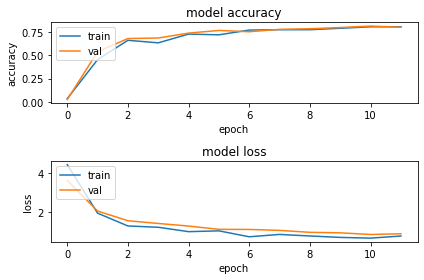

In [19]:
plt.subplot(211)
plt.plot(history['categorical_accuracy'])
plt.plot(history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')# summarize history for loss 



plt.subplot(212)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
plt.tight_layout()
plt.show()

In [37]:
data, label = model.get_next_batch(1, file_path = test_files)

# Here we are Saving the Model for a reload using tf.saved_model.load, Serving Signature is set to Default

In [38]:
model.save_pb_model(file_name = "Model",  first_conv_filter=128, second_conv_filter=64, frequency_size=40, time_size=49, )

INFO:tensorflow:Restoring parameters from checkpath/model_checkpoint.ckpt-20000
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: Model/saved_model.pb


# The Next Lines of code introduces you to TFLITE and TFLITE MICRO
### TFLITE for Android Devices and Micro-Computers
### TFLITE for Micro-controllers and Embedded Devices with low power and generally requiring int8 computations

In [39]:
# directories and tflite micro requires
from tflite_op import *
rep_size = 100
float_model_tflite="work/tfFloat"
quant_model_tflite= "work/tflite"
pb_model_dir = "Model"
tflite_micro = "work/tflite_micro"
#

In [ ]:
# See tflite_op for implementation. Save TFLITE MODEL FOR FLOAT VALUE COMPUTATION
save_float_model(model_path=pb_model_dir, save_path=float_model_tflite)

In [23]:
# # See tflite_op for implementation. Save TFLITE MODEL FOR INT8 VALUE COMPUTATION
save_quantized_model(model_path=pb_model_dir, save_path=quant_model_tflite, rep_files=test_files, rep_data=100)

INFO:tensorflow:Restoring parameters from Model/variables/variables


INFO:tensorflow:Restoring parameters from Model/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input


INFO:tensorflow: tensor name: Reshape_3:0, shape: (1, 1960), type: DT_FLOAT


INFO:tensorflow: tensor name: Reshape_3:0, shape: (1, 1960), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: predictions


INFO:tensorflow:Tensor's key in saved_model's tensor_map: predictions


INFO:tensorflow: tensor name: labels_softmax:0, shape: (1, 38), type: DT_FLOAT


INFO:tensorflow: tensor name: labels_softmax:0, shape: (1, 38), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from Model/variables/variables


INFO:tensorflow:Restoring parameters from Model/variables/variables


INFO:tensorflow:Restoring parameters from Model/variables/variables


INFO:tensorflow:Restoring parameters from Model/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input


INFO:tensorflow: tensor name: Reshape_3:0, shape: (1, 1960), type: DT_FLOAT


INFO:tensorflow: tensor name: Reshape_3:0, shape: (1, 1960), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: predictions


INFO:tensorflow:Tensor's key in saved_model's tensor_map: predictions


INFO:tensorflow: tensor name: labels_softmax:0, shape: (1, 38), type: DT_FLOAT


INFO:tensorflow: tensor name: labels_softmax:0, shape: (1, 38), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from Model/variables/variables


INFO:tensorflow:Restoring parameters from Model/variables/variables


Quantized model is 1550008 bytes


# Now Let us Test the Accuracy from TFLITE... See Implentation in tflite_op.py

In [40]:
# Use our data from our wanted commands
commands_files =[]
for com in ["on", "off",]:
    search_path = os.path.join("dataset", com, '*.wav')
    file = gfile.Glob(search_path)
    np.random.shuffle(file)
    commands_files += file
# Preprocess using the Micro_process Implementation
data, labels = model.get_next_batch(len(commands_files), commands_files)

In [25]:


correct_predictions = 0
for i in range(len(data)):
    correct_predictions += (predict_float(data[i], FLOAT_MODEL_TFLITE) == labels[i])
   

print(' Float model accuracy is %f%% (Number of test samples=%d)' % (
        (correct_predictions * 100) / len(data), len(data)))

 model accuracy is 80.445884% (Number of test samples=8029)


In [26]:
correct_predictions = 0
for i in range(len(data)):
    correct_predictions += (predict_quantized(data[i], MODEL_TFLITE ) == labels[i])
   

print(' Int8 model accuracy is %f%% (Number of test samples=%d)' % (
        (correct_predictions * 100) / len(data), len(data)))

 model accuracy is 79.922780% (Number of test samples=8029)


## For Embedded Devices, Let us covert to Micro

In [42]:
!xxd -i {quant_model_tflite} > {tflite_micro}
REPLACE_TEXT = quant_model_tflite.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {tflite_micro}

In [56]:
# Cat file into txt and Copy to device
!cat {MODEL_TFLITE_MICRO} > t.txt